**PROJECT** :

approximate the price and the error of = **PROTECT MULTI-FIXED COUPON EXPRESS CERTIFICATE** using **Monte Carlo method** and choose a choerent alghoritm for the generation of random numbers  

**Assumptions**

Following the instructions relative to the functioning of the Certificate I decided to use the following =

1) **numpy algorithm** to generate random numbers

 2) **Heston model** to model the *four underlyings* with  *stochastic volatilites* and the relative **Euler scheme** to approximate their processes

3) **Vasiceck model** to model the *stochastic interest rate*

4) **Antithetic Variate** method for *Variance reduction*

in the subsequent I will expose my results with the relative codes , the functioning of the Model used and their theoretical justifications.

    _________ INTRODUCTION _______


Certificates are generally complex derivative instruments whose structure is a  composition of other derivatives like options.
Compute their prices could be difficult mainly because of the fact that we don't have a closed form solution to develope like other simpler instruments.
It is possible to compute the price by pricing the replicating portfolio of derivatives composing their structure or by approximating its payoff composition using numerical methods.



If we decide to follow the second alternative, one of the most efficient way to approximate its price is by using **Monte Carlo method**.

MC is a numerical and probabilistic technique consisting in a alghoritm that performs repeated independent random samples to compute theoretical results when is not possible to rely on closed form solutions.

MC final output is the *estimate of an expectation value* through an arithmetic mean of realizations of iid random variables.




The core of the alghoritm is

1) Z random variable with known distribution.
The estimation we need to compute depend on Z

2) choose a pseudo-random number generator that provides realizations Z(i) of Z1,Z2... distributed as Z

3) the expecation is approximated in this way
$$
{E[f(Z_i)]} \approx \frac{1}{N} \sum_{i=1}^{N} f(Z_i)
$$

( which is unbiased and strongly consistend )

under the hypothesis of Zi is an infinite sequence of iid random variables with finite Expected values , by The Law of large numbers the sampe average converges to the Expected values.

with sample variance:
$$
\sigma^2 = \frac{1}{N-1} \sum_{i=1}^{N} (Z_i - \bar{Z})^2\\
$$
 and standard error:
 $$
 \sigma = \frac{\sigma}{\sqrt{N}}\
 $$

 which is a central feature in  MC alg. Why ?

 The MC error is given by:
 $$
 \texttt{montecarlo_error} = \sqrt{\frac{\texttt{variance}}{N}}
 $$

and we can reduce it in 2 ways =
1)  increasing the length of our sample

2) reducing the variance (among the mothods we studied: control variates / antithetic variates)

In [1]:
import math
import numpy as np
import random
import matplotlib.pyplot as plt

in the following we have an idea of MC simulations for stock prices.

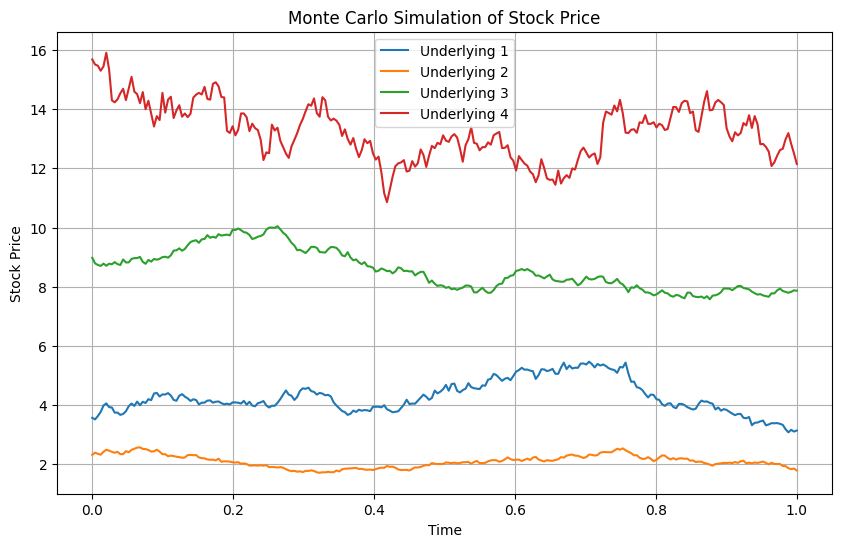

In [44]:
def monte_carlo_stock_price(S0, mu, sigma, T, N, seed):
    np.random.seed(seed)
    dt = T / N
    t = np.linspace(0, T, N)
    dW = np.random.normal(0, np.sqrt(dt), size=(N, 4))
    W = np.cumsum(dW, axis=0)
    drift = (mu - 0.5 * sigma**2) * t[:, np.newaxis]
    diffusion = sigma * W
    S = S0 * np.exp(drift + diffusion)
    return t, S

# Parameters
S0 = np.array([3.668, 2.275, 8.956, 16.286])  # Initial stock prices
mu = np.array([0.05, 0.03, 0.02, 0.04])  # Drifts (expected returns)
sigma = np.array([0.4, 0.3, 0.14, 0.4])  # Volatilities (standard deviations of returns)
T = 1  # Time period (years)
N = 252  # Number of time steps (daily data for one year)
seed = 123  # Random seed

# Generate stock price simulations
t, S = monte_carlo_stock_price(S0, mu, sigma, T, N, seed)

# Plot stock price simulations
plt.figure(figsize=(10, 6))
for i in range(4):
    plt.plot(t, S[:, i], label=f'Underlying {i+1}')

plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Monte Carlo Simulation of Stock Price')
plt.legend()
plt.grid(True)
plt.show()


**RANDOM NUMBER GENERATOR**

LINEAR CONGRUENTIAL GENERATOR VS NP.RANDOM

LCG and BOX MULLER



in the following code I reproduced two fundamental algorithm studied in class:
- the *LCG* for the production of random numbers
- *Box Muller* method used for sampling standard normal distributions both in uivariate and bivariate cases.


In [ ]:
def LCG(x):
    IA = 16807
    IM = 2147483647
    IQ = 127773
    IR = 2836
    AM = 1.0 / IM
    # The next instruction performs integer division (discarding the remainder)
    k = x // IQ
    x = IA * (x - k * IQ) - IR * k
    if x < 0:
        x = x + IM
    return AM * x


# Box-Muller transformation.
def BM(u1, u2):
    Pi = 3.14159265358979
    R = math.sqrt(-2 * math.log(u1))
    alpha = 2 * Pi * u2
    n1 = R * math.cos(alpha)
    n2 = R * math.sin(alpha)
    return n1, n2


def biN(x):
    u1 = LCG(x)
    u2 = LCG(x)
    return BM(u1, u2)


def uniN(x):
    n1, n2 = biN(x)
    if hasattr(uniN, 'hasStored') and uniN.hasStored is True:
        uniN.hasStored = False
        return uniN.stored
    else:
        uniN.stored = n2
        uniN.hasStored = True
        return n1

In [ ]:
seed1 = 546

In [ ]:
num_values = 9  # Numero di valori da generare
values = []  # Lista dei valori generati

x = seed1

#Genera i valori utilizzando l'algoritmo LCG
for _ in range(num_values):
    value = uniN(x)
    values.append(value)
    x = LCG(x)

print(values)

[5.3319318142922475e-42, 5.8674363613909755, 1.232938937728149e-06, 9.025456047283084, 1.1616706192993769e-16, 11.335382846110805, 8.936566922214105e-27, 13.248507526297724, 6.397674574270196e-37]


Despite its desiderable property I decided to not use it.
It is observable by the values produced that the output are not so much accurate when the LGG is  implemented in Python, rather then in other programming lenguages.


**Numpy**

In order to improve the quality of the random numbers to generate is preferable to  use *numpy.random.seed* and *numpy.random.normal()* from *np.random*, a module in the NumPy package that provides functions for generating random numbers.

It is a better choice because of different reasons, the most relevant in this context is  the **quality of random numbers**:

  Numpy uses  more sophisticated algorithms to generate random numbers, such as the:
  
   **MERSENNE TWISTER ALGHORITM**.
   
   MT  is a linear congruential pseudorandom number generator algorithm,which has a longer period and better statistical properties than other used algs such ash LCG.
   It provides a high-quality  and more accurate set of pseudo random numbers


*Alghoritm*

In [30]:
n = 624
m = 397
a = 0x9908B0DF
u, d = 11, 0xFFFFFFFF
s, b = 7, 0x9D2C5680
t, c = 15, 0xEFC60000
l = 18
r = 32 - l
f = 1812433253
w = 32

MT = [0] * n
index = n + 1
lower_mask = (1 << r) - 1
upper_mask = ~lower_mask & 0xFFFFFFFF

# Initialize the generator from a seed
def seed_mt(seed):
    global index
    index = n
    MT[0] = seed & 0xFFFFFFFF
    for i in range(1, n):
        MT[i] = (f * (MT[i-1] ^ (MT[i-1] >> (w-2))) + i) & 0xFFFFFFFF

# Extract a tempered value based on MT[index]
# calling twist() every n numbers
def extract_number():
    global index
    if index >= n:
        if index > n:
            raise ValueError("Generator was never seeded")
        twist()

    y = MT[index]
    y ^= (y >> u) & d
    y ^= (y << s) & b
    y ^= (y << t) & c
    y ^= y >> l

    index += 1
    return y & 0xFFFFFFFF

# Generate the next n values from the series x_i
def twist():
    global index
    for i in range(n):
        x = (MT[i] & upper_mask) | (MT[(i+1) % n] & lower_mask)
        xA = x >> 1
        if x % 2 != 0:
            xA ^= a
        MT[i] = MT[(i + m) % n] ^ xA
    index = 0

# Generate a random number from a standard normal distribution
def standard_normal():
    u1 = extract_number() / 0xFFFFFFFF
    u2 = extract_number() / 0xFFFFFFFF
    z = math.sqrt(-2 * math.log(u1)) * math.cos(2 * math.pi * u2)
    return z

# Test the generator
seed_mt(12346)
random_numbers = [standard_normal() for _ in range(10)]
print(random_numbers)


[0.34760107368323234, 1.293804777332757, 0.3823226530609118, 0.3481720088949471, 0.7509013900241621, 0.18519588132084447, -0.12494625454648192, -1.3738156880285264, 2.080857670319024, -1.028479840409269]


it is evident that the generation of values is more accurate.

*brief explanation*


1) *Initialization*: The algorithm is set up with an initial seed value that determines the starting point of the random number sequence.

2) *Random Number Generation*: The algorithm generates random numbers by performing mathematical operations on its internal state. These operations mix and modify the state to produce a sequence of random numbers.

3) *Twist*: After generating a certain number of random numbers, the algorithm applies a "twist" operation to update its internal state. This ensures that the generated sequence remains unpredictable and doesn't repeat.

4) *Temper*: Before returning a random number, the algorithm applies additional operations to adjust and improve the randomness of the number.

5) *Standard Normal Distribution*: To obtain a standard normal random number, the algorithm uses pairs of random numbers it generates and applies a transformation using the Box-Muller transform. This transformation converts the pairs of random numbers into independent standard normally distributed random numbers.

**DATA**

the *structure of the payoff* and the *explanations of its functioning* are contained in the certificate KIID-section.Objectives

In [2]:
nominal = 100

#underlyings
IRP = [3.668, 2.275, 8.956, 16.286] #initial reference values
redemption_levels = [3.668, 2.275, 8.956, 16.286]
barriers = [2.384, 1.4788, 5.821, 10.586]
barr = np.log(barriers)
redempt = np.log(redemption_levels)
K = np.log(IRP)

V = [0.04,0.03,0.03,0.04]
G = [np.log(strike) for strike in IRP]

#short-rate
r0 = 0.01  #initial short-rate
kappa = 0.04 #mean reversion speed for short rate
theta = 0.02 #long-term mean of short rante
sigma = 0.02  # Volatility of short rate

#volatility
kappa_v = [1.5, 0.8, 1.2, 0.9] # Mean-reversion speeds
theta_v = [0.04, 0.03, 0.05, 0.04]  # Long-term average volatilities
Lambda = [0.05,0.04,0.04,0.05] #volatility of volatility

#coupons
coupon_payment = 1.84  # Coupon payment



In [3]:
correlation_matrix = np.array([
    [1.0, 0.3, 0.3, 0.3, -0.2, -0.2, -0.2, -0.2, 0.1],
    [0.3, 1.0, 0.4, 0.4, -0.3, -0.3, -0.3, -0.3, 0.1],
    [0.3, 0.4, 1.0, 0.5, -0.2, -0.2, -0.2, -0.2, 0.1],
    [0.3, 0.4, 0.5, 1.0, -0.2, -0.2, -0.2, -0.2, 0.1],
    [-0.2, -0.3, -0.2, -0.2, 1.0, 0.1, 0.1, 0.1, 0.2],
    [-0.2, -0.3, -0.2, -0.2, 0.1, 1.0, 0.2, 0.2, 0.1],
    [-0.2, -0.3, -0.2, -0.2, 0.1, 0.2, 1.0, 0.2, 0.1],
    [-0.2, -0.3, -0.2, -0.2, 0.1, 0.2, 0.2, 1.0, 0.1],
    [0.1, 0.1, 0.1, 0.1, 0.2, 0.1, 0.1, 0.1, 1.0]
])

L = np.linalg.cholesky(correlation_matrix)


 to manage properly MULTIVARIATE NORMAL
 $$
Z \overset{}{\sim} (\mu, \hat{\Sigma})
$$
we can use the **Cholesky factoriazion** as seen in class.

In particular I've choosen to use the one offered by np.linalg, a module in the NumPy package that provides functions and methods for linear algebra.

1)Input: The function takes a matrix as input. The matrix should be square, Hermitian, and positive-definite. Non-square matrices or matrices that do not meet these criteria will result in an error.

2) Cholesky Decomposition: The function performs the Cholesky decomposition on the input matrix and returns a lower triangular matrix L.

3) Lower Triangular Matrix: The lower triangular matrix L obtained from the Cholesky decomposition has the property that the conjugate transpose of L is equal to the original input matrix.

4) The Cholesky decomposition is commonly used in numerical computations involving positive-definite matrices, such as generating samples from multivariate normal distributions.

**PAYOFF FUNCTIONS**

these are the payoff functions I created to facilitate the *discount* and *storage* of the payoff in indicated variables.

1)The integral of r: has been approximated by the **trapezoidal rule**

( T.R. i.e. numerical integration technique used to approximate the definite integral of a function. It works by approximating the area under the curve of the function as a series of trapezoids, then  calculates the integral by summing the areas, providing an approximation of the integral value.
Its error is  O(h^2) and is influenced by the second derivative of the function. As the function becomes more curved or non-linear, the trapezoidal rule may have a larger error compared to other numerical integration methods that are more accurate for such functions, such as Simpson's rule. )

then used in discount_factor and anti_disc_factor to discount the payoff.

2) everything is stored in variables

3)antithetic_fucntion and mean_disc_p = used for the antithetic version of the montecarlo simulation.


In [4]:
def calculate_payoff(payoff, coupon_payment, r, r0, sumr, dt, sum_discounted_payoffs):
    integral_r = (0.5 * (r0 - r) + sumr) * dt
    discounted_payoff = payoff * np.exp(-integral_r)
    sum_discounted_payoffs = sum_discounted_payoffs + discounted_payoff
    return sum_discounted_payoffs, discounted_payoff

In [5]:
def calculate_antithetic(payoff, coupon_payment,r,r0,antir,sum_antir, sum_discounted_payoffs,antisum_disc_payoffs,dt):
    anti_integral = (0.5 * (r0-antir) + sum_antir) * dt
    anti_disc_payoffs = payoff*np.exp(-anti_integral)
    antisum_disc_payoffs = antisum_disc_payoffs + anti_disc_payoffs
    return antisum_disc_payoffs,anti_disc_payoffs


In [6]:
def calculate_mean_discounted_payoff(sum_discounted_payoffs, antisum_disc_payoffs):
    mean_discounted_payoff = (sum_discounted_payoffs + antisum_disc_payoffs) / 2
    return mean_discounted_payoff


**MC ALGHORITM**

the main alghoritm is enclosed in a function , taking as imputs all the relevant data showed before.

**COMMENT OF RESULT AND MCE : AT THE END OF THE FILE**

**MODELS**

**HESTON MODEL**
$$
 dS(t) = \mu  S(t)  dt + \sqrt{v(t)}  S(t)  dW1(t)
 \\
 dv(t) = \kappa  (\theta - v(t))  dt + \xi  \sqrt{v(t)}  dW2(t)
 \\
 $$
 $$
 \\
 v(t)\ following\ a\ square-root\ CIR\ process
 \\
 $$

$$
dW1(t)\ and\ dW2(t)\ are\ Wiener\ processes\ (i.e.,\ continuous\ random\ walks)\ with\ correlation\ ρ
$$


 *why Heston model?*
 - I choose it  over the Black-Scholes because, by incorporating the stochastic volatility, it reflects better the real behaviour of financial assets , particularly because volatility often exhibits patterns such as skewness (asymmetry in implied volatilities) and clustering (periods of high or low volatility).
This  allows for a more accurate representation of market conditions and improves the model's ability to price.

- As we can see, the asset prices follow a geometric Brownian motion, similar to the Black-Scholes model. However, the volatility is modeled as a mean-reverting process with  a separate stochastic differential equation. This means that the volatility fluctuates around a long-term average value and tends to revert back to that average over time.


**VASICECK MODEL**


The Vasicek model assumes that the short-term interest rate follows a mean-reverting process. It is defined by the following SDE:
$$
dr(t) = \kappa(\theta - r(t)) dt + \sigma_r dW(t)
\\
$$
$$
 r(t): short-term\ interest\ rate\ in\ t,
 \\κ: speed\ of\ mean\ reversion,
 \\
 θ: long-term\ mean,
 \\ σ: volatility\ parameter,
 \\  dW(t):Wiener\ process\ increment.
 \\
 $$
$$
\sigma_r \sim \mathcal{N}
$$

The model allows negative interest rates and exhibits mean reversion towards the long-term mean θ. It does not capture the volatility smile observed in market interest rates.


*why Vasiceck?*


I decided to use it instead of CIR model to not further increase the variability of the price and of the error.

*CIR model* introduces the square root process σ√(r(t)) to capture the volatility of interest rates, which leads to a *non-constant volatility* .
(it captures the volatility smile on the market and prevents interest rates from becoming negative by using the square root process, showing a  non-linear relationship between the interest rate and volatility).
$$
dr(t) = \kappa(\theta - r(t)) dt + \sigma\sqrt{r(t)} dW(t)
$$

It would be a good candidate for our problem in MC, but considering that the choice of the correlations and other parameters , done in a non calibrated way, alterates results sufficiently, I decided to mantain the volatility of the interest rate contstant.

For a proof = I  added the square root of the process in the stochastic part and observed an increase in the price and in dispersion indices, so I decided to left Vasiceck only.

**EULER SCHEME**

$$
\begin{align*}
\\
Heston\ model \\
 Gi = stock values ; \\
Vi = volatilities
\end{align*}
\\
$$
$$
\begin{align*}
G_i &= G_{i-1} \ + (r - \frac{1}{2}V_{i-1})\Delta t + \sqrt{V_{i-1}\Delta t}\epsilon_S\ \\
V_i &=  V_{i-1} \ + \kappa(\theta - V_{i-1})\Delta t + \Lambda\sqrt{V_{i-1}\Delta t}\epsilon_S\
\end{align*}
$$

\\

$$
\begin{align*}
\\
 ri_1 = interest\ rate\ Vasiceck   \\
\end{align*}
$$


$$
r_i = r_{i-1} + \kappa (\theta - r_{i-1}) \Delta t + \sigma \sqrt{\Delta t} \epsilon_i
$$
\\
$$
\begin{align*}
\\
ri_2 = interest \ rate\ CIR
\end{align*}
\\
$$


$$
r_i = r_{i-1} + \kappa (\theta - r_{i-1}) \Delta t + \sigma \sqrt{r_{i-1}} \sqrt{\Delta t} \epsilon_i
$$


The Euler scheme is a numerical method used to approximate the solutions of ordinary differential equations (ODEs). It  discretizes the continuous ODE into small time steps. At each time step, the value of the solution is updated based on the derivative of the ODE at that point.




The Euler scheme is a first-order method, meaning that its accuracy is proportional to the size of the time step used.

10000 simulations

In [10]:
def monte_carlo(nominal, IRP, redemption_levels, barriers, V, kappa, theta, sigma, kappa_v, theta_v, Lambda, coupon_payment, r0, N, M, T, seed):
    dt = 1 / M
    sqrt_dt = np.sqrt(dt)
    np.random.seed(seed)
    mean = 0
    tot_payoff = 0

    for i in range(N):
        G1 = np.log(IRP[0])
        G2 = np.log(IRP[1])
        G3 = np.log(IRP[2])
        G4 = np.log(IRP[3])
        V_1 = V[0]
        V_2 = V[1]
        V_3 = V[2]
        V_4 = V[3]
        r = r0
        sumr = 0
        sum_discounted_payoffs = 0
        payoff = 0

        epsilon_shape = (T, M, 9)
        epsilon_values = np.random.normal(size=epsilon_shape)

        for y in range(T):
            for j in range(M):
                epsilon0, epsilon1, epsilon2, epsilon3, epsilon4, epsilon5, epsilon6, epsilon7, epsilon8 = epsilon_values[y, j]

                eta_1 = L[0, 0] * epsilon0
                eta_2 = L[1, 0] * epsilon0 + L[1, 1] * epsilon1
                eta_3 = L[2, 0] * epsilon0 + L[2, 1] * epsilon1 + L[2, 2] * epsilon2
                eta_4 = L[3, 0] * epsilon0 + L[3, 1] * epsilon1 + L[3, 2] * epsilon2 + L[3, 3] * epsilon3
                eta_v1 = L[4, 0] * epsilon0 + L[4, 1] * epsilon1 + L[4, 2] * epsilon2 + L[4, 3] * epsilon3 + L[4, 4] * epsilon4
                eta_v2 = L[5, 0] * epsilon0 + L[5, 1] * epsilon1 + L[5, 2] * epsilon2 + L[5, 3] * epsilon3 + L[5, 4] * epsilon4 + L[5, 5] * epsilon5
                eta_v3 = L[6, 0] * epsilon0 + L[6, 1] * epsilon1 + L[6, 2] * epsilon2 + L[6, 3] * epsilon3 + L[6, 4] * epsilon4 + L[6, 5] * epsilon5 + L[6, 6] * epsilon6
                eta_v4 = L[7, 0] * epsilon0 + L[7, 1] * epsilon1 + L[7, 2] * epsilon2 + L[7, 3] * epsilon3 + L[7, 4] * epsilon4 + L[7, 5] * epsilon5 + L[7, 6] * epsilon6 + L[7, 7] * epsilon7
                eta_r = L[8, 0] * epsilon0 + L[8, 1] * epsilon1 + L[8, 2] * epsilon2 + L[8, 3] * epsilon3 + L[8, 4] * epsilon4 + L[8, 5] * epsilon5 + L[8, 6] * epsilon6 + L[8, 7] * epsilon7 + L[8, 8] * epsilon8

                V_1 = V_1 * kappa_v[0] * theta_v[0] * dt - (kappa_v[0] * dt) * V_1 * Lambda[0] * sqrt_dt * np.sqrt(V_1) * eta_v1
                V_2 = V_2 * kappa_v[1] * theta_v[1] * dt - (kappa_v[1] * dt) * V_2 * Lambda[1] * sqrt_dt * np.sqrt(V_2) * eta_v2
                V_3 = V_3 * kappa_v[2] * theta_v[2] * dt - (kappa_v[2] * dt) * V_3 * Lambda[2] * sqrt_dt * np.sqrt(V_3) * eta_v3
                V_4 = V_4 * kappa_v[3] * theta_v[3] * dt - (kappa_v[3] * dt) * V_3 * Lambda[3] * sqrt_dt * np.sqrt(V_4) * eta_v4

                if V_1 < 0 and V_2 < 0 and V_3 < 0 and V_4 < 0:
                    V_1 = abs(V_1)
                    V_2 = abs(V_2)
                    V_3 = abs(V_3)
                    V_4 = abs(V_4)

                G1 = G1 + (r - V_1 / 2) * dt + np.sqrt(V_1) * sqrt_dt * eta_1
                G2 = G2 + (r - V_2 / 2) * dt + np.sqrt(V_2) * sqrt_dt * eta_2
                G3 = G3 + (r - V_3 / 2) * dt + np.sqrt(V_3) * sqrt_dt * eta_3
                G4 = G4 + (r - V_4 / 2) * dt + np.sqrt(V_4) * sqrt_dt * eta_4

                reference1 = G1
                reference2 = G2
                reference3 = G3
                reference4 = G4

                r = r + (kappa * theta * dt) - (kappa * dt * r) + sigma * sqrt_dt * eta_r  # Vasicek
                sumr += r

            if y == 1 or y == 2 or y == 3:
                payoff = payoff + coupon_payment
                sum_discounted_payoffs, discounted_payoff = calculate_payoff(payoff, coupon_payment, r, r0, sumr, dt, sum_discounted_payoffs)

            if y == 4 or y == 5 or y == 6 or y == 7 or y == 8 or y == 9 or y == 10 or y == 11 or y == 12 or y == 13 or y == 14 or y == 15 or y == 16 or y == 17 or y == 18 or y == 19:
                if reference1 >= redempt[0] and reference2 >= redempt[1] and reference3 >= redempt[2] and reference4 >= redempt[3]:
                    payoff += 100
                    sum_discounted_payoffs, discounted_payoff = calculate_payoff(payoff, coupon_payment, r, r0, sumr, dt,sum_discounted_payoffs)
                    break
            else:
                payoff = payoff + coupon_payment
                sum_discounted_payoffs, discounted_payoff = calculate_payoff(payoff, coupon_payment, r, r0, sumr, dt,sum_discounted_payoffs)

            if y == 20:
                if reference1 >= barr[0] and reference2 >= barr[1] and reference3 >= barr[2] and reference4 >= barr[3]:
                    payoff += nominal + coupon_payment
                    sum_discounted_payoffs, discounted_payoff = calculate_payoff(payoff, coupon_payment, r, r0, sumr, dt,sum_discounted_payoffs)

                else:
                    worst_performance = min(G1 / K[0], G2 / K[1], G3 / K[2], G4 / K[3])
                    cash_amount = nominal * worst_performance
                    payoff += coupon_payment + cash_amount
                    sum_discounted_payoffs, discounted_payoff = calculate_payoff(payoff, coupon_payment, r, r0, sumr, dt,sum_discounted_payoffs)

        tot_payoff = tot_payoff + sum_discounted_payoffs

    mean = tot_payoff / N
    variance = np.sum((discounted_payoff - mean) ** 2) / (N - 1)
    st_error = np.sqrt(variance)
    MC_Error = np.sqrt(variance / N)

    return mean, variance, st_error, MC_Error

# Test the function
result = monte_carlo(nominal=100, IRP=[3.668, 2.275, 8.956, 16.286],
                                redemption_levels=[3.668, 2.275, 8.956, 16.286], barriers=[2.384, 1.4788, 5.821, 10.586],
                                V = [0.035,0.03,0.03,0.04], kappa=0.04, theta=0.02, sigma=0.02,
                                kappa_v=[1.5, 0.8, 1.2, 0.9], theta_v=[0.04, 0.03, 0.05, 0.04],
                                Lambda=[0.05, 0.04, 0.04, 0.05], coupon_payment=1.84,
                                r0=0.01, N=10000, M=90, T=20, seed=656)

# Print the results
mean, variance, st_error, MC_Error = result
print("Price: ", mean)
print("Variance: ", variance)
print("Standard Error: ", st_error)
print("Monte Carlo Error: ", MC_Error)


Price:  131.1168798985647
Variance:  0.04907176745656401
Standard Error:  0.221521483058786
Monte Carlo Error:  0.00221521483058786


1000 simulations

In [12]:
result = monte_carlo(nominal=100, IRP=[3.668, 2.275, 8.956, 16.286],
                                redemption_levels=[3.668, 2.275, 8.956, 16.286], barriers=[2.384, 1.4788, 5.821, 10.586],
                                V = [0.035,0.03,0.03,0.04], kappa=0.04, theta=0.02, sigma=0.02,
                                kappa_v=[1.5, 0.8, 1.2, 0.9], theta_v=[0.04, 0.03, 0.05, 0.04],
                                Lambda=[0.05, 0.04, 0.04, 0.05], coupon_payment=1.84,
                                r0=0.01, N=1000, M=90, T=20, seed=656)

# Print the results
mean, variance, st_error, MC_Error = result
print("Price: ", mean)
print("Variance: ", variance)
print("Standard Error: ", st_error)
print("Monte Carlo Error: ", MC_Error)


Price:  132.36690839116986
Variance:  13.781604236747826
Standard Error:  3.7123583120097425
Monte Carlo Error:  0.11739507756608804


100 simulations

In [13]:
result = monte_carlo(nominal=100, IRP=[3.668, 2.275, 8.956, 16.286],
                                redemption_levels=[3.668, 2.275, 8.956, 16.286], barriers=[2.384, 1.4788, 5.821, 10.586],
                                V = [0.035,0.03,0.03,0.04], kappa=0.04, theta=0.02, sigma=0.02,
                                kappa_v=[1.5, 0.8, 1.2, 0.9], theta_v=[0.04, 0.03, 0.05, 0.04],
                                Lambda=[0.05, 0.04, 0.04, 0.05], coupon_payment=1.84,
                                r0=0.01, N=100, M=90, T=20, seed=656)

# Print the results
mean, variance, st_error, MC_Error = result
print("Price: ", mean)
print("Variance: ", variance)
print("Standard Error: ", st_error)
print("Monte Carlo Error: ", MC_Error)


Price:  132.80459326296778
Variance:  17.730177527509557
Standard Error:  4.210721734751604
Monte Carlo Error:  0.4210721734751604


**BLACK and SCHOLES**

$$
Euler\ approximation
\\
S[t+\Delta t] = S[t] + r  S[t] \Delta t + \sigma \ S[t] \ \epsilon \ \sqrt{\Delta t}
$$

In [32]:
correlation_matrix = np.array([
    [1.0, 0.3, 0.3, 0.3, 0.01],
    [0.3, 1.0, 0.4, 0.4, 0.02],
    [0.3, 0.4, 1.0, 0.5, 0.03],
    [0.3, 0.4, 0.5, 1.0, 0.02],
    [0.2, 0.3, 0.2, 0.01,1.0],

])

L = np.linalg.cholesky(correlation_matrix)


def monte_carlo_BS(nominal, IRP, redemption_levels, barriers, sigmaG, kappa, theta, sigma, kappa_v, theta_v, Lambda, coupon_payment, r0, N, M, T, seed):
    dt = 1 / M
    sqrt_dt = np.sqrt(dt)
    np.random.seed(seed)
    mean = 0
    tot_payoff = 0

    for i in range(N):
        G1 = np.log(IRP[0])
        G2 = np.log(IRP[1])
        G3 = np.log(IRP[2])
        G4 = np.log(IRP[3])
        r = r0
        sumr = 0
        sum_discounted_payoffs = 0
        payoff = 0

        epsilon_shape = (T, M, 5)
        epsilon_values = np.random.normal(size=epsilon_shape)

        for y in range(T):
            for j in range(M):
                epsilon0, epsilon1, epsilon2, epsilon3, epsilon4 = epsilon_values[y, j]
                eta_1 = L[0, 0] * epsilon0
                eta_2 = L[1, 0] * epsilon0 + L[1, 1] * epsilon1
                eta_3 = L[2, 0] * epsilon0 + L[2, 1] * epsilon1 + L[2, 2] * epsilon2
                eta_4 = L[3, 0] * epsilon0 + L[3, 1] * epsilon1 + L[3, 2] * epsilon2 + L[3, 3] * epsilon3
                eta_r = L[4, 0] * epsilon0 + L[4, 1] * epsilon1 + L[4, 2] * epsilon2 + L[4, 3] * epsilon3 + L[4, 4] * epsilon4

                G1 = G1 + (r * G1) * dt + sigmaG[0]*G1 * sqrt_dt * eta_1
                G2 = G2 + (r * G2) * dt + sigmaG[1]*G2 * sqrt_dt * eta_2
                G3 = G3 + (r * G3) * dt + sigmaG[2]*G3 * sqrt_dt * eta_3
                G4 = G4 + (r * G4) * dt + sigmaG[3]*G4 * sqrt_dt * eta_4

                reference1 = G1
                reference2 = G2
                reference3 = G3
                reference4 = G4

                r = r + (kappa * theta * dt) - (kappa * dt * r) + sigma * sqrt_dt * eta_r # Vasicek
                sumr += r

            if y == 1 or y == 2 or y == 3:
                payoff = payoff + coupon_payment
                sum_discounted_payoffs, discounted_payoff = calculate_payoff(payoff, coupon_payment, r, r0, sumr, dt, sum_discounted_payoffs)

            if y == 4 or y == 5 or y == 6 or y == 7 or y == 8 or y == 9 or y == 10 or y == 11 or y == 12 or y == 13 or y == 14 or y == 15 or y == 16 or y == 17 or y == 18 or y == 19:
                if reference1 >= redempt[0] and reference2 >= redempt[1] and reference3 >= redempt[2] and reference4 >= redempt[3]:
                    payoff += 100
                    sum_discounted_payoffs, discounted_payoff = calculate_payoff(payoff, coupon_payment, r, r0, sumr, dt,sum_discounted_payoffs)
                    break
            else:
                payoff = payoff + coupon_payment
                sum_discounted_payoffs, discounted_payoff = calculate_payoff(payoff, coupon_payment, r, r0, sumr, dt,sum_discounted_payoffs)

            if y == 20:
                if reference1 >= barr[0] and reference2 >= barr[1] and reference3 >= barr[2] and reference4 >= barr[3]:
                    payoff += nominal + coupon_payment
                    sum_discounted_payoffs, discounted_payoff = calculate_payoff(payoff, coupon_payment, r, r0, sumr, dt,sum_discounted_payoffs)

                else:
                    worst_performance = min(G1 / K[0], G2 / K[1], G3 / K[2], G4 / K[3])
                    cash_amount = nominal * worst_performance
                    payoff += coupon_payment + cash_amount
                    sum_discounted_payoffs, discounted_payoff = calculate_payoff(payoff, coupon_payment, r, r0, sumr, dt,sum_discounted_payoffs)

        tot_payoff = tot_payoff + sum_discounted_payoffs

    mean = tot_payoff / N
    variance = np.sum((discounted_payoff - mean) ** 2) / (N - 1)
    st_error = np.sqrt(variance)
    MC_Error = np.sqrt(variance / N)

    return mean, variance, st_error, MC_Error,

# Test the function
result = monte_carlo_BS(nominal=100, IRP=[3.668, 2.275, 8.956, 16.286],
                                redemption_levels=[3.668, 2.275, 8.956, 16.286], barriers=[2.384, 1.4788, 5.821, 10.586],
                                sigmaG =[0.02,0.01,0.02,0.03], kappa=0.04, theta=0.02, sigma=0.02,
                                kappa_v=[2.0,1.2,1.5, 1.0], theta_v=[0.04, 0.03, 0.05, 0.04],
                                Lambda=[0.08,0.06,0.07,0.09], coupon_payment=1.84,
                                r0=0.01, N=10000, M=90, T=20, seed=656)

# Print the results
mean, variance, st_error, MC_Error = result
print("Price: ", mean)
print("Variance: ", variance)
print("Standard Error: ", st_error)
print("Monte Carlo Error: ", MC_Error)

Price:  123.58416643399858
Variance:  0.02913152995120372
Standard Error:  0.1706796119962889
Monte Carlo Error:  0.0017067961199628888


**VARIANCE REDUCTION**

**Antithetic Variates technique**

is based on the construction of a *new variable*  as the mean of  processes $$Yi\ ,\ Yi_a $$ constructed by using the **antithetic pairs** of the distribution implied in the original process function.
$$Y = f(Z), \quad Z \sim \mathcal{N}(0, 1)$$
$$ Z \sim Z'$$ , $$\text{corr}(Z, Z') = -1$$

$$take\ a\ sequence\ then:\ Z_{ai} = -Z_i$$

$$Y_{\text{ai}} = f(Z_{\text{ai}})$$

$$Y_{\text{av}} = \frac{{Y_{\text{avg}} + Y_{\text{ai (avg)}}}}{2}$$

*Antithtetic pairs*: same distributions, perfectly anticorrelated.
Correlation depends on f.

Their mean have good statistical properties, that is to say, are  unbiased estimators and also strongly consistent.

Briefly speaking we have variance reduction iif :
$$\text{cov}(Y_i, Y_{\text{a}}) < 0$$ and this depend on the choice on the *function* that generates the processes.

For monotonic functions the distribution are perfectly anticorrelated and the we reach our variance reduction.



*why AV* ?

- I decided to implement AV rather then CV due to the *correlation structure* of the certificate that could reach to some complications in improving CV.
Av, on the contrary, does not need particular adjustments, since the pairs generated are negatively correlated.

- also given the presence of negative correlations AV lead to an overall significant variance reduction  (negative and positive fluctuations cancel out each other)

- Av is independet from the model

10000 simulations

In [14]:
def monte_carlo_anthitetic_variance_reduction(nominal, IRP, redemption_levels, barriers, V, kappa, theta, sigma, kappa_v, theta_v, Lambda, coupon_payment, r0, N, M, T, seed):
    dt = 1 / M
    sqrt_dt = np.sqrt(dt)
    np.random.seed(seed)
    mean = 0
    tot_payoff = 0
    tot_payoff_varrred = 0
    for i in range(N):
        G1 = G[0]
        G2 = G[1]
        G3 = G[2]
        G4 = G[3]
        V_1 = V[0]
        V_2 = V[1]
        V_3 = V[2]
        V_4 = V[3]
        r = r0
        antiG1 = G[0]
        antiG2 = G[1]
        antiG3 = G[2]
        antiG4 = G[3]
        antiV_1= V[0]
        antiV_2= V[1]
        antiV_3=V[2]
        antiV_4=V[3]
        antir = r0
        G1_av = 0
        G2_av = 0
        G3_av = 0
        G4_av = 0
        V1_av = 0
        V2_av = 0
        V3_av = 0
        V4_av = 0
        r_av = 0
        sumr = 0
        discounted_payoff = 0
        sum_discounted_payoffs = 0
        payoff = 0
        antipayoff = 0
        sum_antir = 0
        antisum_disc_payoffs = 0
        antipayoff = 0
        epsilon_shape = (T, M, 9)
        epsilon_values = np.random.normal(size=epsilon_shape)

        for y in range(T):
            for j in range(M):
                epsilon0, epsilon1, epsilon2, epsilon3, epsilon4, epsilon5, epsilon6, epsilon7, epsilon8 = epsilon_values[y, j]
                epsilon0_neg, epsilon1_neg, epsilon2_neg, epsilon3_neg, epsilon4_neg, epsilon5_neg, epsilon6_neg, epsilon7_neg, epsilon8_neg = -epsilon0, -epsilon1, -epsilon2, -epsilon3, -epsilon4, -epsilon5, -epsilon6, -epsilon7, -epsilon8


                eta_1 = L[0, 0] * epsilon0
                eta_2 = L[1, 0] * epsilon0 + L[1, 1] * epsilon1
                eta_3 = L[2, 0] * epsilon0 + L[2, 1] * epsilon1 + L[2, 2] * epsilon2
                eta_4 = L[3, 0] * epsilon0 + L[3, 1] * epsilon1 + L[3, 2] * epsilon2 + L[3, 3] * epsilon3
                eta_v1 = L[4, 0] * epsilon0 + L[4, 1] * epsilon1 + L[4, 2] * epsilon2 + L[4, 3] * epsilon3 + L[4, 4] * epsilon4
                eta_v2 = L[5, 0] * epsilon0 + L[5, 1] * epsilon1 + L[5, 2] * epsilon2 + L[5, 3] * epsilon3 + L[5, 4] * epsilon4 + L[5, 5] * epsilon5
                eta_v3 = L[6, 0] * epsilon0 + L[6, 1] * epsilon1 + L[6, 2] * epsilon2 + L[6, 3] * epsilon3 + L[6, 4] * epsilon4 + L[6, 5] * epsilon5 + L[6, 6] * epsilon6
                eta_v4 = L[7, 0] * epsilon0 + L[7, 1] * epsilon1 + L[7, 2] * epsilon2 + L[7, 3] * epsilon3 + L[7, 4] * epsilon4 + L[7, 5] * epsilon5 + L[7, 6] * epsilon6 + L[7, 7] * epsilon7
                eta_r = L[8, 0] * epsilon0 + L[8, 1] * epsilon1 + L[8, 2] * epsilon2 + L[8, 3] * epsilon3 + L[8, 4] * epsilon4 + L[8, 5] * epsilon5 + L[8, 6] * epsilon6 + L[8, 7] * epsilon7 + L[8, 8] * epsilon8

                eta_1neg = L[0, 0] * epsilon0_neg
                eta_2neg = L[1, 0] * epsilon0_neg + L[1, 1] * epsilon1_neg
                eta_3neg = L[2, 0] * epsilon0_neg + L[2, 1] * epsilon1_neg + L[2, 2] * epsilon2_neg
                eta_4neg = L[3, 0] * epsilon0_neg + L[3, 1] * epsilon1_neg + L[3, 2] * epsilon2_neg + L[3, 3] * epsilon3_neg
                eta_v1neg = L[4, 0] * epsilon0_neg + L[4, 1] * epsilon1_neg + L[4, 2] * epsilon2_neg + L[4, 3] * epsilon3_neg + L[4, 4] * epsilon4_neg
                eta_v2neg = L[5, 0] * epsilon0_neg + L[5, 1] * epsilon1_neg + L[5, 2] * epsilon2_neg + L[5, 3] * epsilon3_neg + L[5, 4] * epsilon4_neg + L[5, 5] * epsilon5_neg
                eta_v3neg = L[6, 0] * epsilon0_neg + L[6, 1] * epsilon1_neg + L[6, 2] * epsilon2_neg + L[6, 3] * epsilon3_neg + L[6, 4] * epsilon4_neg + L[6, 5] * epsilon5_neg + L[6, 6] * epsilon6_neg
                eta_v4neg = L[7, 0] * epsilon0_neg + L[7, 1] * epsilon1_neg + L[7, 2] * epsilon2_neg + L[7, 3] * epsilon3_neg + L[7, 4] * epsilon4_neg + L[7, 5] * epsilon5_neg + L[7, 6] * epsilon6_neg + L[7, 7] * epsilon7_neg
                eta_rneg = L[8, 0] * epsilon0_neg + L[8, 1] * epsilon1_neg + L[8, 2] * epsilon2_neg + L[8, 3] * epsilon3_neg + L[8, 4] * epsilon4_neg + L[8, 5] * epsilon5_neg + L[8, 6] * epsilon6_neg + L[8, 7] * epsilon7_neg + L[8, 8] * epsilon8_neg

                V_1 = V_1 * kappa_v[0] * theta_v[0] * dt - (kappa_v[0] * dt) * V_1 * Lambda[0] * sqrt_dt * np.sqrt(V_1) * eta_v1
                V_2 = V_2 * kappa_v[1] * theta_v[1] * dt - (kappa_v[1] * dt) * V_2 * Lambda[1] * sqrt_dt * np.sqrt(V_2) * eta_v2
                V_3 = V_3 * kappa_v[2] * theta_v[2] * dt - (kappa_v[2] * dt) * V_3 * Lambda[2] * sqrt_dt * np.sqrt(V_3) * eta_v3
                V_4 = V_4 * kappa_v[3] * theta_v[3] * dt - (kappa_v[3] * dt) * V_3 * Lambda[3] * sqrt_dt * np.sqrt(V_4) * eta_v4

                antiV_1 = antiV_1 * kappa_v[0] * theta_v[0] * dt - (kappa_v[0] * dt) * V_1 * Lambda[0] * sqrt_dt *np.sqrt(V_1)  * (eta_v1neg)
                antiV_2 = antiV_2 * kappa_v[0] * theta_v[0] * dt - (kappa_v[0] * dt) * V_1 * Lambda[0] * sqrt_dt *np.sqrt(V_1)  * (eta_v2neg)
                antiV_3 = antiV_3 * kappa_v[0] * theta_v[0] * dt - (kappa_v[0] * dt) * V_1 * Lambda[0] * sqrt_dt *np.sqrt(V_1)  * (eta_v3neg)
                antiV_4 = antiV_4 * kappa_v[0] * theta_v[0] * dt - (kappa_v[0] * dt) * V_1 * Lambda[0] * sqrt_dt *np.sqrt(V_1)  * (eta_v4neg)


                if V_1 < 0 and V_2 < 0 and V_3 < 0 and V_4 < 0:
                    V_1 = abs(V_1)
                    V_2 = abs(V_2)
                    V_3 = abs(V_3)
                    V_4 = abs(V_4)

                if antiV_1<0 and antiV_2 <0 and antiV_3 <0 and antiV_4 <0:
                   antiV_1=abs(antiV_1)
                   antiV_2=abs(antiV_2)
                   antiV_3=abs(antiV_3)
                   antiV_4=abs(antiV_4)

                G1 = G1 + (r - V_1 / 2) * dt + np.sqrt(V_1) * sqrt_dt * eta_1
                G2 = G2 + (r - V_2 / 2) * dt + np.sqrt(V_2) * sqrt_dt * eta_2
                G3 = G3 + (r - V_3 / 2) * dt + np.sqrt(V_3) * sqrt_dt * eta_3
                G4 = G4 + (r - V_4 / 2) * dt + np.sqrt(V_4) * sqrt_dt * eta_4

                reference1 = G1
                reference2 = G2
                reference3 = G3
                reference4 = G4

                antiG1 = antiG1 + (r - antiV_1/2) * dt + np.sqrt(V_1) * sqrt_dt * (eta_1neg)
                antiG2 = antiG2 + (r - antiV_2/2) * dt + np.sqrt(V_2) * sqrt_dt * (eta_2neg)
                antiG3 = antiG3 + (r - antiV_3/2) * dt + np.sqrt(V_3) * sqrt_dt * (eta_3neg)
                antiG4 = antiG4 + (r - antiV_4/2) * dt + np.sqrt(V_4) * sqrt_dt * (eta_4neg)

                G1_av = (G1+antiG1)/2

                G2_av = (G2+antiG2)/2

                G3_av = (G3+antiG3)/2

                G4_av = (G4+antiG4)/2



                V1_av = (G1+antiG1)/2
                V2_av = (G2+antiG2)/2
                V3_av = (G3+antiG3)/2
                V4_av = (G4+antiG4)/2

                ant_reference1 = G1_av
                ant_reference2 = G2_av
                ant_reference3 = G3_av
                ant_reference4 = G4_av


                r = r + (kappa * theta * dt) - (kappa * dt * r) + sigma * sqrt_dt * eta_r
                sumr += r

                antir = antir + (kappa * theta * dt) - ( kappa * dt * antir ) + sigma * sqrt_dt * (eta_rneg) #Vasiceck
                sum_antir += antir

                r_av = (r+antir)/2
                r_av += r_av

            if y == 1 or y == 2 or y == 3:
                payoff = payoff + coupon_payment
                sum_discounted_payoffs, discounted_payoff = calculate_payoff(payoff, coupon_payment, r, r0, sumr, dt, sum_discounted_payoffs)
                antisum_disc_payoffs,anti_disc_payoffs = calculate_antithetic(payoff, coupon_payment,r,r0,antir,sum_antir, sum_discounted_payoffs,antisum_disc_payoffs,dt)
                mean_discpayoff=calculate_mean_discounted_payoff(sum_discounted_payoffs, antisum_disc_payoffs)

            if y == 4 or y == 5 or y == 6 or y == 7 or y == 8 or y == 9 or y == 10 or y == 11 or y == 12 or y == 13 or y == 14 or y == 15 or y == 16 or y == 17 or y == 18 or y == 19:
                if reference1 >= redempt[0] and reference2 >= redempt[1] and reference3 >= redempt[2] and reference4 >= redempt[3]:
                    payoff += 100
                    sum_discounted_payoffs, discounted_payoff = calculate_payoff(payoff, coupon_payment, r, r0, sumr, dt,sum_discounted_payoffs)
                    antisum_disc_payoffs,anti_disc_payoffs = calculate_antithetic(payoff, coupon_payment,r,r0,antir,sum_antir, sum_discounted_payoffs,antisum_disc_payoffs,dt)
                    mean_discpayoff=calculate_mean_discounted_payoff(sum_discounted_payoffs, antisum_disc_payoffs)
                    break
            else:
                payoff = payoff + coupon_payment
                sum_discounted_payoffs, discounted_payoff = calculate_payoff(payoff, coupon_payment, r, r0, sumr, dt,sum_discounted_payoffs)
                antisum_disc_payoffs,anti_disc_payoffs = calculate_antithetic(payoff, coupon_payment,r,r0,antir,sum_antir, sum_discounted_payoffs,antisum_disc_payoffs,dt)
                mean_discpayoff=calculate_mean_discounted_payoff(sum_discounted_payoffs, antisum_disc_payoffs)
            if y == 20:
                if reference1 >= barr[0] and reference2 >= barr[1] and reference3 >= barr[2] and reference4 >= barr[3]:
                    payoff += nominal + coupon_payment
                    sum_discounted_payoffs, discounted_payoff = calculate_payoff(payoff, coupon_payment, r, r0, sumr, dt,sum_discounted_payoffs)
                    antisum_disc_payoffs,anti_disc_payoffs = calculate_antithetic(payoff, coupon_payment,r,r0,antir,sum_antir, sum_discounted_payoffs,antisum_disc_payoffs,dt)
                    mean_discpayoff=calculate_mean_discounted_payoff(sum_discounted_payoffs, antisum_disc_payoffs)
                else:
                    worst_performance = min(G1 / K[0], G2 / K[1], G3 / K[2], G4 / K[3])
                    cash_amount = nominal * worst_performance
                    payoff += coupon_payment + cash_amount
                    sum_discounted_payoffs, discounted_payoff = calculate_payoff(payoff, coupon_payment, r, r0, sumr, dt,sum_discounted_payoffs)
                    antisum_disc_payoffs,anti_disc_payoffs = calculate_antithetic(payoff, coupon_payment,r,r0,antir,sum_antir, sum_discounted_payoffs,antisum_disc_payoffs,dt)
                    mean_discpayoff=calculate_mean_discounted_payoff(sum_discounted_payoffs, antisum_disc_payoffs)

        tot_payoff = tot_payoff + sum_discounted_payoffs
        tot_payoff_varrred= tot_payoff_varrred + mean_discpayoff

    mean = tot_payoff / N
    variance = np.sum((discounted_payoff - mean) ** 2) / (N - 1)
    st_error = np.sqrt(variance)
    MC_Error = np.sqrt(variance / N)

    mean_varred = tot_payoff_varrred / N
    variance_varred = np.sum((mean_discpayoff - mean_varred) ** 2) / (N - 1)
    st_error_varred = np.sqrt(variance_varred)
    MC_Error_varred = np.sqrt(variance_varred / N)

    return mean, variance, st_error, MC_Error, mean_varred, variance_varred,st_error_varred,MC_Error_varred

# Test the function
mean, variance, st_error, MC_Error,mean_varred, variance_varred, st_error_varred, MC_Error_varred = monte_carlo_anthitetic_variance_reduction(nominal=100, IRP=[3.668, 2.275, 8.956, 16.286],
                                redemption_levels=[3.668, 2.275, 8.956, 16.286], barriers=[2.384, 1.4788, 5.821, 10.586],
                                V = [0.035,0.03,0.03,0.04], kappa=0.04, theta=0.02, sigma=0.02,
                                kappa_v=[1.5, 0.8, 1.2, 0.9], theta_v=[0.04, 0.03, 0.05, 0.04],
                                Lambda=[0.05, 0.04, 0.04, 0.05], coupon_payment=1.84,
                                r0=0.01, N=10000, M=90, T=20, seed=656)
print("Price",mean)
print("Variance",variance)
print("Standard Error",st_error)
print("MonteCarlo Error",MC_Error)

print("Price with var reduction",mean_varred)
print("Variance with variance reduction",variance_varred)
print("standard error var reduction", st_error_varred)
print("MC with var reduction",MC_Error_varred)

Price 131.1168798985647
Variance 0.04907176745656401
Standard Error 0.221521483058786
MonteCarlo Error 0.00221521483058786
Price with var reduction 134.2428846280092
Variance with variance reduction 0.003266650847123977
standard error var reduction 0.05715462227260344
MC with var reduction 0.0005715462227260344


**percentage change**

In [43]:
pcMCE = ((MC_Error - MC_Error_varred) / MC_Error_varred) *100
print(pcMCE)
pcSD = ((st_error - st_error_varred) / st_error_varred) *100
print(pcMCE)

-84.90329353098505
-84.90329353098505


1000 simulations

In [17]:
mean, variance, st_error, MC_Error,mean_varred, variance_varred, st_error_varred, MC_Error_varred = monte_carlo_anthitetic_variance_reduction(nominal=100, IRP=[3.668, 2.275, 8.956, 16.286],
                                redemption_levels=[3.668, 2.275, 8.956, 16.286], barriers=[2.384, 1.4788, 5.821, 10.586],
                                V = [0.035,0.03,0.03,0.04], kappa=0.04, theta=0.02, sigma=0.02,
                                kappa_v=[1.5, 0.8, 1.2, 0.9], theta_v=[0.04, 0.03, 0.05, 0.04],
                                Lambda=[0.05, 0.04, 0.04, 0.05], coupon_payment=1.84,
                                r0=0.01, N=1000, M=90, T=20, seed=656)
print("Price",mean)
print("Variance",variance)
print("Standard Error",st_error)
print("MonteCarlo Error",MC_Error)

print("Price with var reduction",mean_varred)
print("Variance with variance reduction",variance_varred)
print("standard error var reduction", st_error_varred)
print("MC with var reduction",MC_Error_varred)

Price 132.36690839116986
Variance 13.781604236747826
Standard Error 3.7123583120097425
MonteCarlo Error 0.11739507756608804
Price with var reduction 135.81211852890942
Variance with variance reduction 7.310825491708206
standard error var reduction 2.7038538221783006
MC with var reduction 0.08550336538235326


100 simulations

In [19]:
mean, variance, st_error, MC_Error,mean_varred, variance_varred, st_error_varred, MC_Error_varred = monte_carlo_anthitetic_variance_reduction(nominal=100, IRP=[3.668, 2.275, 8.956, 16.286],
                                redemption_levels=[3.668, 2.275, 8.956, 16.286], barriers=[2.384, 1.4788, 5.821, 10.586],
                                V = [0.035,0.03,0.03,0.04], kappa=0.04, theta=0.02, sigma=0.02,
                                kappa_v=[1.5, 0.8, 1.2, 0.9], theta_v=[0.04, 0.03, 0.05, 0.04],
                                Lambda=[0.05, 0.04, 0.04, 0.05], coupon_payment=1.84,
                                r0=0.01, N=100, M=90, T=20, seed=656)

print("Price",mean)
print("Variance",variance)
print("Standard Error",st_error)
print("MonteCarlo Error",MC_Error)

print("Price with var reduction",mean_varred)
print("Variance with variance reduction",variance_varred)
print("standard error var reduction", st_error_varred)
print("MC with var reduction",MC_Error_varred)


Price 132.80459326296778
Variance 17.730177527509557
Standard Error 4.210721734751604
MonteCarlo Error 0.4210721734751604
Price with var reduction 134.3361907338447
Variance with variance reduction 5.77038754690146
standard error var reduction 2.4021630974814054
MC with var reduction 0.24021630974814054


**GREEKS**

in order to compute sensitiveness of the Certificate's price with respect to the most relevant variables we can develope the computation of the **fundametal greeks** of derivatives.
In the subsequent we can observe the results in their *approximated* form.
It is not possible to compute the greeks in closed form for this particlar certificate due to its particular structure, for this reason I've not included the error due to the approximation.

- **APPROXIMATED VALUES** using **FINITE DIFFERENCE METHOD**

$$
\Delta = \frac{V(S + h) - V(S - h)}{2h}
$$
\
$$
\Gamma = \frac{V(S + h) - 2V(S) + V(S - h)}{h^2}
$$
\
$$
\Theta = -\frac{V(t + h) - V(t - h)}{2h}
$$
\
$$
\rho = \frac{V(r + h) - V(r - h)}{2h}
$$
\
$$
Vega = \frac{V(\sigma + h) - V(\sigma - h)}{2h}
$$

1)Choose a small increment for each variable in the pricing model.
 The variables of interest are underlying asset price, time to expiration, volatility, and interest rate.

2)Calculate the  price for the original set of parameters.

3)Perturb one of the variables by adding or subtracting the increment from its original value, while keeping the other variables constant.

4)Recalculate the option price using the perturbed set of parameters.

5)Compute the numerical derivative of the option price with respect to the perturbed variable using the finite difference formula

**Delta**

In [ ]:
deltaS = [irp * 0.01 for irp in IRP]

#print(deltaG)
S_up = []
for i in range(len(IRP)):
    S_up.append(IRP[i] + deltaS[i])

print(S_up)
print(IRP)

S_down = []
for i in range(len(IRP)):
    S_down.append(IRP[i] - deltaS[i])
print(S_down)


[3.70468, 2.2977499999999997, 9.04556, 16.44886]
[3.668, 2.275, 8.956, 16.286]
[3.63132, 2.25225, 8.866439999999999, 16.123140000000003]


In [ ]:
mean_up,variance_up,standard_error_up,MC_Error_up = monte_carlo(nominal=100, IRP = S_up,
                                redemption_levels=[3.668, 2.275, 8.956, 16.286], barriers=[2.384, 1.4788, 5.821, 10.586],
                                V =[0.035,0.03,0.03,0.04], kappa=0.04, theta=0.02, sigma=0.02,
                                kappa_v=[1.5, 0.8, 1.2, 0.9], theta_v=[0.04, 0.03, 0.05, 0.04],
                                Lambda=[0.05, 0.04, 0.04, 0.05], coupon_payment=1.84,
                                r0=0.01, N=1000, M=90, T=20, seed=656)

In [ ]:
mean_down,variance_down,standard_error_down,MC_Error_down  = monte_carlo(nominal=100, IRP = S_down,
                                redemption_levels=[3.668, 2.275, 8.956, 16.286], barriers=[2.384, 1.4788, 5.821, 10.586],
                                V =[0.035,0.03,0.03,0.04], kappa=0.04, theta=0.02, sigma=0.02,
                                kappa_v=[1.5, 0.8, 1.2, 0.9], theta_v=[0.04, 0.03, 0.05, 0.04],
                                Lambda=[0.05, 0.04, 0.04, 0.05], coupon_payment=1.84,
                                r0=0.01, N=1000, M=90, T=20, seed=656)

In [ ]:
delta1 =(mean_up - mean_down )/ 2*deltaS[0]
delta2 =(mean_up - mean_down )/ 2*deltaS[1]
delta3 = (mean_up - mean_down )/ 2*deltaS[2]
delta4 = (mean_up - mean_down )/ 2*deltaS[3]
print(delta1)
print(delta2)
print(delta3)
print(delta4)

0.06877942610833584
0.04265899520078082
0.16793580704096397
0.3053821520175457


**Gamma**

In [ ]:
gamma1 = (mean_up - 2*mean + mean_down)/(deltaS[0]**2)
gamma2 = (mean_up - 2*mean + mean_down)/(deltaS[1]**2)
gamma3 = (mean_up - 2*mean + mean_down)/(deltaS[2]**2)
gamma4 = (mean_up - 2*mean + mean_down)/(deltaS[3]**2)
print(gamma1)
print(gamma2)
print(gamma3)
print(gamma4)

162.25857954782006
421.79703420518103
27.21686843333462
8.230713084384579


**Theta**

In [ ]:
delta_T = 1
T = 20
T_up = T + delta_T
mean_Tup,variance_Tup,standard_error_Tup,MC_Error_Tup = monte_carlo(nominal=100, IRP=[3.668, 2.275, 8.956, 16.286],
                                redemption_levels=[3.668, 2.275, 8.956, 16.286], barriers=[2.384, 1.4788, 5.821, 10.586],
                                V = [0.035,0.03,0.03,0.04], kappa=0.04, theta=0.02, sigma=0.02,
                                kappa_v=[1.5, 0.8, 1.2, 0.9], theta_v=[0.04, 0.03, 0.05, 0.04],
                                Lambda=[0.05, 0.04, 0.04, 0.05], coupon_payment=1.84,
                                r0=0.01, N=1000, M=90, T=T_up, seed=656)

In [ ]:
T_down = T - delta_T
mean_Tdown,variance_Tup,standard_error_Tup,MC_Error_Tup = monte_carlo(nominal=100, IRP=[3.668, 2.275, 8.956, 16.286],
                                redemption_levels=[3.668, 2.275, 8.956, 16.286], barriers=[2.384, 1.4788, 5.821, 10.586],
                                V = [0.035,0.03,0.03,0.04], kappa=0.04, theta=0.02, sigma=0.02,
                                kappa_v=[1.5, 0.8, 1.2, 0.9], theta_v=[0.04, 0.03, 0.05, 0.04],
                                Lambda=[0.05, 0.04, 0.04, 0.05], coupon_payment=1.84,
                                r0=0.01, N=1000, M=90, T=T_down, seed=656)

In [ ]:
theta = -(mean_Tup - mean_Tdown)/(2*delta_T)
print(theta)

-4.15035180970483


**Vega**

In [ ]:
Vsqrt = np.sqrt(V)
deltaV = [v * 0.01 for v in Vsqrt]

#print(deltaG)
V_up = []
for i in range(len(V)):
    V_up.append((V[i] + deltaV[i])**2)

#print(V_up)


V_down = []
for i in range(len(V)):
    V_down.append((V[i] - deltaV[i])**2)
#print(V_down)

[0.0017640000000000002, 0.0010069230484541327, 0.0010069230484541327, 0.0017640000000000002]
[0.001444, 0.0007990769515458672, 0.0007990769515458672, 0.001444]


In [ ]:
mean_Vup,variance_Vup,standard_error_Vup,MC_Error_Vup = monte_carlo(nominal=100, IRP = [3.668, 2.275, 8.956, 16.286] ,
                                redemption_levels=[3.668, 2.275, 8.956, 16.286], barriers=[2.384, 1.4788, 5.821, 10.586],
                                V = V_up, kappa=0.04, theta=0.02, sigma=0.02,
                                kappa_v=[1.5, 0.8, 1.2, 0.9], theta_v=[0.04, 0.03, 0.05, 0.04],
                                Lambda=[0.05, 0.04, 0.04, 0.05], coupon_payment=1.84,
                                r0=0.01, N=1000, M=90, T=20, seed=656)

In [ ]:
mean_Vdown,variance_Vdown,standard_error_Vdown,MC_Error_Vdown = monte_carlo(nominal=100, IRP = [3.668, 2.275, 8.956, 16.286] ,
                                redemption_levels=[3.668, 2.275, 8.956, 16.286], barriers=[2.384, 1.4788, 5.821, 10.586],
                                V = V_down, kappa=0.04, theta=0.02, sigma=0.02,
                                kappa_v=[1.5, 0.8, 1.2, 0.9], theta_v=[0.04, 0.03, 0.05, 0.04],
                                Lambda=[0.05, 0.04, 0.04, 0.05], coupon_payment=1.84,
                                r0=0.01, N=1000, M=90, T=20, seed=656)

In [ ]:
Vega1 = (mean_Vup-mean_Vdown)/(2*deltaV[0])
Vega2 = (mean_Vup-mean_Vdown)/(2*deltaV[1])
Vega3 = (mean_Vup-mean_Vdown)/(2*deltaV[2])
Vega4 = (mean_Vup-mean_Vdown)/(2*deltaV[3])

print(Vega1)
print(Vega2)
print(Vega3)
print(Vega4)


0.0
0.0
0.0
0.0


**Rho**

In [ ]:
delta_r = 0.01 * r0
r_up = r0 + delta_r

In [ ]:
mean_rup,variance_rup,standard_error_rup,MC_Error_rup = monte_carlo(nominal=100, IRP=[3.668, 2.275, 8.956, 16.286],
                                redemption_levels=[3.668, 2.275, 8.956, 16.286], barriers=[2.384, 1.4788, 5.821, 10.586],
                                V = [0.035,0.03,0.03,0.04], kappa=0.04, theta=0.02, sigma=0.02,
                                kappa_v=[1.5, 0.8, 1.2, 0.9], theta_v=[0.04, 0.03, 0.05, 0.04],
                                Lambda=[0.05, 0.04, 0.04, 0.05], coupon_payment=1.84,
                                r0=r_up, N=1000, M=90, T=20, seed=656)

In [ ]:
r_down = r0 - delta_r

In [ ]:
mean_rdown,variance_rdown,standard_error_rdown,MC_Error_rdown = monte_carlo(nominal=100, IRP=[3.668, 2.275, 8.956, 16.286],
                                redemption_levels=[3.668, 2.275, 8.956, 16.286], barriers=[2.384, 1.4788, 5.821, 10.586],
                                V = [0.035,0.03,0.03,0.04], kappa=0.04, theta=0.02, sigma=0.02,
                                kappa_v=[1.5, 0.8, 1.2, 0.9], theta_v=[0.04, 0.03, 0.05, 0.04],
                                Lambda=[0.05, 0.04, 0.04, 0.05], coupon_payment=1.84,
                                r0=r_down, N=1000, M=90, T=20, seed=656)

In [ ]:
Rho = (mean_rup - mean_rdown) / (2*delta_r)
print(Rho)

9.569799785253963


**FINAL COMMENT ON RESULTS AND ON MONTE CARLO ERROR**

I can now summarize the most relevant observations about my results

After looking at produced values, dispersion indices and MCE, I can finally states that the obtained price , which is around 131 Euro, is consistent with the expected result and with the model assumptions and semplficiations I introduced.

I've just explained the reasons why I've choosen Heston model and Vasicek to approximate the main processes. To briefly recap:  a stochastic interest rate model incorporates randomness or uncertainty in interest rate movements and for this reason it captures real-world fluctuations.  
Furthermore, considering that the Certificate underlyings are four stocks, it is obvious that the dynamic of each of them and the relative volatilities have a considerable impact on the price of the instrument, for this reason it is convenient to choose a model that encapsulate all these features in the evaluation. Heston model offers, not only a different SDE for volatilites, but also correlates all the processes, making the problem even more realistic.



*Parameters and results*

The *correlation structure* is a sensible feature of the problem and in this particular pricing issue it represents the main source of noise of the price.
The main weakness with correlation is that I didn't *calibrate* with market values and this lead to inconsistencies and possible valuation error.
Despite that , I tried to choose choerent values:  

* negative correlations between stocks and their respect volatilties due to their inversely related relathion (higher volatility=lower stock prices);
* positive correlation between stocks and interest rates , due to a pseudo-sectorial choice : financial(bank)-sector underlyngs are generally positive correlated with interest rates due to the banks economical role and to their source of profitability;
* positive correlations between volatilities of the stocks and interest rates for the same logic.

Comparing the price by Heston and the one by B&S, we can see how the values of the error indices sensibly decrease in B&S , producing a more reliable price(123 Euro) , even without refining it with a variance reduction method.
The correlation matrix has been sensibly reduced, without changing or perturbating other values. If I had considered no correlation structure probabily I would reached a value around 100 euro.

Not only correlations have been affected by the arbitraryness of the choice, but also the following parameters:
  
1)*Heston model volatilities parameters*  
*   V = [0.035,0.03,0.03,0.03] volatilities of the underlyings
*   kappa_v = [0.04, 0.03, 1.5, 1.0]  Mean-reversion speeds
*   theta_v = [0.04, 0.03, 0.05, 0.04]   Long-term average volatilities
*   Lambda = [0.05,0.04,0.04,0.05] volatility of volatility

2) *short-rate*
*   r0 = 0.01  initial short-rate
*   kappa = 0.5 mean reversion speed for short rate
*   theta = 0.03 long-term mean of short rante
*   sigma = 0.02  Volatility of short rate

even thoungh I didn't calibrate to market data, I tried to choose values the more realistic as possible , looking at general values adopted for the parameters , for example in the case of the volatilities for the underlyings, I searched for some historical volatilities for selected Italian banking stocks on an annualized basis, that approximaltely ranges around:
*   Banco BPM (BAMI.MI) : 25-35%
*   Mediobanca (MDBI.MI): 20-30%
*   UniCredit (UCG.MI): 30% - 40%
*   Intesa Sanpaolo (ISP.MI): 20%-30%

3) *variables not included(costs)*:

another fact to consider is that I do not include in my function any type of variables related to the composition of costs of the certificate such as: taxes, all the possible fees and transaction costs. This is also another possible cause of alteration in the result

*Discounted payoff pricing and results*

the certificate has been priced following the structure of its payoff rather then its replicating portfolio (composition of options and other features). I didn't write the payoff composition in the code but only linked the reference (KIID). Pricing in this way need other semplifcations in the code structure , for example:

*  the division of period in quarters , in order to discount the periodal coupons and the flattening of every period in rounded values (every month has 30 days)

*   the semplification assumed by the text of the project: all contractual events are all on day 27 of relevant month

*  the approximation of the integral in the discount factor using trapezoidal rule. I just exaplained the functioning of the method. More efficient method could be used instead, for example Simpson rule. This could probabily be another source of noise when analyzing the pricing procedure.


*Greeks and results*

Greeks are largely important to evaulate se sensitivity of the price to its main variables. Their quantification is important to asses risk and potential profitability of derivatives, Traders uses greeks and also VAR to make assumptions about Expected Profit al Losses.

In our problem, Greeks have beeh approximated with central difference and second order central difference for the only second derivative(gamma).

Results may me compromised by the general error in the pricing function but I can try to give a general comment about the obtained values:



*   Delta values suggest that the underlyings with higher sensitivity to price change is the last one (Intesa SP)

*   Gamma : the one whose delta has an  higher sensitivity to price changes is the second one (MedioBanca)

*   0 values for Vegas suggest no sensitivity to change in implied volatilies


*   negative theta suggest that the price will decrease with an order of magnitude given by the value obtained




*  positive rho : the price will increase with interest rate with an order of magnitude given by the value obtained







.



*MONTE CARLO ERROR, VARIANCE REDUCTION AND RESULTS*

After describing all the possible sources of noise affecting the model we can finally discuss about Monte Carlo error.

 Monte Carlo error  refers to the *estimation error* or uncertainty associated with using *Monte Carlo simulation methods*, therefore it is  not directly related to systematic errors or biases that may arise from the model assumptions,simulation methodology, or input data used in the Monte Carlo simulation, hence it is necessary to discuss about it in our problem.

 I've just showed the formula to compute it and I've also said the two ways we can use to reduce its value and  then improve the precision of the estimates.

 In order to verify the accuracy and the precision of my simulations I've improved both the alternatives.



1.   **INCREASE  NUMBER OF SIMULATIONS**
after setting the algortihm I generated result for N = 100, 1000, 10000.

N = 100
- Price:  132.80459326296778
- Variance:  17.730177527509557
- Standard Error:  4.210721734751604
- Monte Carlo Error:  0.4210721734751604

N = 1000
- Price:  132.36690839116986
- Variance:  13.781604236747826
- Standard Error:  3.7123583120097425
- Monte Carlo Error:  0.11739507756608804

N = 10000
- Price:  131.1168798985647
- Variance:  0.04907176745656401
- Standard Error:  0.221521483058786
- Monte Carlo Error:  0.00221521483058786


as we can see  the MC error reduces from the 40% to 11% when increasing N from 100 to 1000 and finally reaches 0.2% with 10000 simulations. This result highlight the reduction in error simulations.

Explanations:

Mathematically, the standard error of the estimated quantities in Monte Carlo simulation decreases as the square root of the sample size. This means that doubling the sample size can potentially reduce the standard error by approximately a factor of √2.

By using a larger sample size, the Monte Carlo simulation can capture a more comprehensive representation of the input distributions, resulting in more accurate and reliable estimates of the quantities of interest.
However, increasing the sample size also requires *more computational resources* and time for simulation resulting inefficient in some cases.
In my project after running the functions in the trhee cases above we pass from a timing of : 8 secs(100), to 1min(1000), to 5 min (10000).


2.   **VARIANCE REDUCTION : ANTITHETIC METHOD**

VR methods are preferred because of the increase of accuracy and faster convergence.
Among the 2 methods we studied in class I decided to develope the antithetic variates version and the reasons are explained above when introducing the method functioning.

To briefly recall the most important points: I preferred AV for my project because: it is straightforward to implement ( an advantage when dealing with complex values to approximate, like pricing Certificates); preserving expected values of the simulations , the outcomes and parameters reamins unbiased and it does not depend on model parameters, another good reason , considering the aribtraryness of the values of most parameters; finally it improves converges and efficiency because relies only on athitetic distributions and their correlations.

After implementing the technique I runned the problem in the three cases and, as we can see from the results, the improvement on the MCE is undoubly stronger.
The code still run slowly, but it is only due to the number of simultaions involved.

N =100
- Price 132.80459326296778
- Variance 17.730177527509557
- Standard Error 4.210721734751604
- MonteCarlo Error 0.4210721734751604

- Price with var reduction 134.3361907338447
- Variance with variance reduction 5.77038754690146
- standard error var reduction 2.4021630974814054
- MC with var reduction 0.24021630974814054

N=1000
- Price 132.36690839116986
- Variance 13.781604236747826
- Standard Error 3.7123583120097425
- MonteCarlo Error 0.11739507756608804

- Price with var reduction 135.81211852890942
- Variance with variance reduction 7.310825491708206
- standard error var reduction 2.7038538221783006
- MC with var reduction 0.08550336538235326

N = 10000
- Price 131.1168798985647
- Variance 0.04907176745656401
- Standard Error 0.221521483058786
- MonteCarlo Error 0.00221521483058786

- Price with var reduction 134.2428846280092
- Variance with variance reduction 0.003266650847123977
- standard error var reduction 0.05715462227260344
- MC with var reduction 0.0005715462227260344




as we can see the reduction of the error is considerably high in all the three cases, showing heavy percentage changes.
As we can notice , the price in the VR case is higher then the original one, this is due to the fact that reducing the variance will increase the price of the cartificate, as it is less risky.

The reference example for this analysis is the values of N= 10000. We can see that MCE goes from 11% to 8% to finally reach 0.05% , which is a good value and reaches our final objective.




